# Description du projet et des jeux de données

L'objectif du projet est de mettre en place un système de recommandation. 

Dans le cas présent, nous allons utiliser un dataset sur des livres avec trois tables : [dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/).

**BX-Users**
Contains the users. Note that user IDs (`User-ID`) have been anonymized and map to integers. Demographic data is provided (`Location`, `Age`) if available. Otherwise, these fields contain NULL-values.

**BX-Books**
Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (`Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavours (`Image-URL-S`, `Image-URL-M`, `Image-URL-L`), i.e., small, medium, large. These URLs point to the Amazon web site. 

**BX-Book-Ratings**
Contains the book rating information. Ratings (`Book-Rating`) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

# Librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Chargement des fichiers et quelques statistiques

## Lecture des fichiers

In [2]:
df_users = pd.read_csv("../input/BX-Users.csv", sep=";",delimiter=";", header=0, encoding='ansi')
print("taille du jeu de donnees Users :", df_users.shape)
df_users.head(10)

taille du jeu de donnees Users : (278858, 3)


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
5,6,"santa monica, california, usa",61.0
6,7,"washington, dc, usa",NaN
7,8,"timmins, ontario, canada",NaN
8,9,"germantown, tennessee, usa",NaN
9,10,"albacete, wisconsin, spain",26.0


In [3]:
#certaines données sont mal formées avec des "" dans les champs. Utilisation d'error_bad_lines
df_books = pd.read_csv("../input/BX-Books.csv", sep=";",delimiter=";", header=0, encoding='ansi', error_bad_lines=False)
print("taille du jeu de donnees Books :", df_books.shape)
df_books.head(10)

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


taille du jeu de donnees Books : (271360, 8)


C:\Users\bigdata\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...
6,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...
7,0671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...
8,0679425608,Under the Black Flag: The Romance and the Real...,David Cordingly,1996,Random House,http://images.amazon.com/images/P/0679425608.0...,http://images.amazon.com/images/P/0679425608.0...,http://images.amazon.com/images/P/0679425608.0...
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...


In [4]:
df_ratings = pd.read_csv("../input/BX-Book-Ratings.csv", sep=";",delimiter=";", header=0, encoding='ansi')
print("taille du jeu de donnees Book Ratings :", df_ratings.shape)
df_ratings.head(10)

taille du jeu de donnees Book Ratings : (1149780, 3)


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
5,276733,2080674722,0
6,276736,3257224281,8
7,276737,0600570967,6
8,276744,038550120X,7
9,276745,342310538,10


## Quelques statistiques descriptives

__Statistiques sur les Users__

In [5]:
nb_LinesUsers = df_users.shape[0]
print("# Nb Lines File Users : ", nb_LinesUsers)

# Nb Lines File Users :  278858


In [6]:
nb_Users = len(df_users['User-ID'].unique())
print("# Users : ", nb_Users)

# Users :  278858


Tous les users sont uniques.

__Statistiques sur les Livres__

In [7]:
nb_LinesBooks = df_books.shape[0]
print("# Nb Lines File Books : ", nb_LinesBooks)

# Nb Lines File Books :  271360


In [8]:
nb_Books = len(df_books['ISBN'].unique())
print("# Books : ", nb_Books)

# Books :  271360


Tous les livres sont uniques.

__Statistiques sur les Rating__

In [9]:
nb_LinesRatings = df_ratings.shape[0]
print("# Nb Lines File Ratings : ", nb_LinesRatings)

# Nb Lines File Ratings :  1149780


In [10]:
set_scores = list(set(df_ratings["Book-Rating"]))
set_scores

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [11]:
# Checking if the user has rated the same book twice, in that case we just take max of them
df_validationRatings = df_ratings.groupby(['User-ID','ISBN']).aggregate(np.max)
print("Probleme de duplication dans ratings :", len(df_validationRatings) != nb_LinesRatings)

Probleme de duplication dans ratings : False


Plus d'un million de notations sur des livres compris entre 0 et 10 par des utilisateurs et il n'y a pas de duplication avec un utilisateur ayant noté deux fois le même livre.

In [12]:
sparsity = round(1.0 - nb_LinesRatings/(1.0*(nb_Books*nb_Users)),5)
print("Sparsity : ", sparsity)

Sparsity :  0.99998


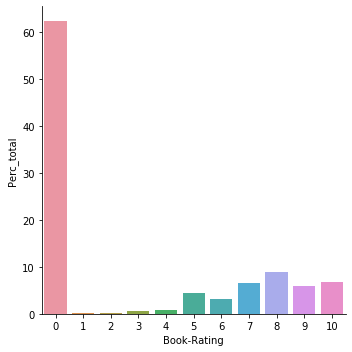

In [13]:
count_ratings = df_ratings.groupby('Book-Rating').count()
count_ratings['Book-Rating'] = count_ratings.index
count_ratings['Perc_total']=round(count_ratings['User-ID']*100/count_ratings['User-ID'].sum(),1)
sns.catplot(x= "Book-Rating", y="Perc_total",data=count_ratings,kind='bar')

Nous avons pu voir simplement :
* Le nombre d'utilisateurs, le nombre de livres, la sparsité de la matrice users par livre 
* La distribution des notes sur les livres : la modalité 0 est la plus représentée mais est une note implicite.

# Construction du Dataset

1. Ne comprenant pas la note 0, on va se passer de l'ensemble des notes implicites ce qui va réduire considérablement le dataset initial de ratings

In [14]:
df_ratingsRed = df_ratings[df_ratings["Book-Rating"]>0]
len(df_ratingsRed)

433671

2. Faisons le merge avec les users présents dans la table User

In [15]:
rating_user = pd.merge(df_ratingsRed,df_users,on='User-ID')
rating_user.head(5)

,User-ID,ISBN,Book-Rating,Location,Age
0,276726,0155061224,5,"seattle, washington, usa",NaN
1,276729,052165615X,3,"rijeka, n/a, croatia",16.0
2,276729,0521795028,6,"rijeka, n/a, croatia",16.0
3,276736,3257224281,8,"salzburg, salzburg, austria",NaN
4,276737,0600570967,6,"sydney, new south wales, australia",14.0


In [16]:
len(rating_user)

433671

Pas de perte, on retrouve tous les users.

In [17]:
df = pd.merge(rating_user, df_books, on="ISBN")

In [18]:
len(df)

383842

Il y a des livres qui ne sont pas présents dans les deux tables.

In [19]:
df.head(5)

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276726,0155061224,5,"seattle, washington, usa",NaN,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
1,276729,052165615X,3,"rijeka, n/a, croatia",16.0,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
2,276729,0521795028,6,"rijeka, n/a, croatia",16.0,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...
3,276744,038550120X,7,"torrance, california, usa",NaN,A Painted House,JOHN GRISHAM,2001,Doubleday,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...
4,11676,038550120X,10,"n/a, n/a, n/a",NaN,A Painted House,JOHN GRISHAM,2001,Doubleday,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...


On va recalculer les statistiques sur base des données présentes sur le nombre d'Users, de books, sparsite

In [20]:
nb_Users = len(df['User-ID'].unique())
print("# Users : ", nb_Users)

# Users :  68091


In [21]:
nb_Books = len(df['ISBN'].unique())
print("# Books : ", nb_Books)

# Books :  149836


In [22]:
nb_Ratings = df.shape[0]
print("# Nb Ratings : ", nb_Ratings)

# Nb Ratings :  383842


In [23]:
sparsity = round(1.0 - nb_Ratings/(1.0*(nb_Books*nb_Users)),5)
print("Sparsity : ", sparsity)

Sparsity :  0.99996


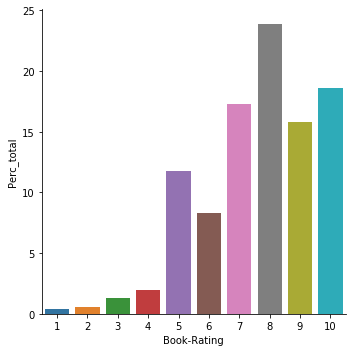

In [24]:
count_ratings = df.groupby('Book-Rating').count()
count_ratings['Book-Rating'] = count_ratings.index
count_ratings['Perc_total']=round(count_ratings['User-ID']*100/count_ratings['User-ID'].sum(),1)
sns.catplot(x= "Book-Rating", y="Perc_total",data=count_ratings,kind='bar')

Sans surprise, on retrouve la forme de la distribution en enlevant la notation implicite.

# Recommandations

## Recommandations non personnelles basées sur l'indicateur IMDB

Visualisation du top 10 des livres les plus commentées avec calcul de la moyenne des scores des utilisateurs.

In [25]:
# Finding the average rating for book and the number of ratings for each book
avg_book_rating = pd.DataFrame(df.groupby('ISBN')['Book-Rating'].agg(['mean','count']))
avg_book_rating.sort_values(['count'],ascending=False)[:10]

,mean,count
ISBN,,
0316666343,8.185290,707
0971880107,4.390706,581
0385504209,8.435318,487
0312195516,8.182768,383
0060928336,7.887500,320
059035342X,8.939297,313
0142001740,8.452769,307
0446672211,8.142373,295
044023722X,7.338078,281


In [26]:
avg_rating_all = df['Book-Rating'].mean()
print("La moyenne des notes sur l'ensemble des livres ", avg_rating_all)

La moyenne des notes sur l'ensemble des livres  7.626700569505161


In [27]:
#calculate the percentile count. It gives the no of ratings at least 70% of the books have
min_reviews = np.percentile(avg_book_rating['count'],70)
print("Min reviews pour 70% percentile des livres ", min_reviews)

Min reviews pour 70% percentile des livres  2.0


Dans notre DataSet, il y a beaucoup de livres qui ont très peu de notations. 

In [28]:
#Pondération entre le rating du book et le rating de tous les books et je tire vers C (la moyenne des scores) si pas assez de notations et sinon vers R (la moyenne des scores des utilisateurs pour ce livre) 
def weighted_rating(x, m=min_reviews, C=avg_rating_all):
    v = x['count']
    R = x['mean']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [29]:
#On réduit le dataset initial par rapport au nombre minimum de reviews correspondant au quantile 70 dans le cas présent
book_score = avg_book_rating[avg_book_rating['count']>min_reviews]
#On applique le score IMDB
book_score['Score IMDB'] = book_score.apply(weighted_rating, axis=1) 
book_score.head()

C:\Users\bigdata\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,mean,count,Score IMDB
ISBN,,,
0002005018,7.666667,9,7.659400
0002116286,7.250000,4,7.375567
0002239183,7.333333,3,7.450680
0002240114,6.750000,4,7.042234
0002243962,5.750000,4,6.375567


In [30]:
#Petite bidouille pour la jointure
book_score["ISBN"] = book_score.index
book_score.index.name = None
#On garde uniquement les champs qui nous intéressent
df_books_util = df_books.drop(['Book-Author', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],axis=1)
book_score = pd.merge(book_score,df_books_util,on='ISBN')
book_score.head(5)

C:\Users\bigdata\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,mean,count,Score IMDB,ISBN,Book-Title,Year-Of-Publication
0,7.666667,9,7.659400,0002005018,Clara Callan,2001
1,7.250000,4,7.375567,0002116286,There's A Seal in my Sleeping Bag,1992
2,7.333333,3,7.450680,0002239183,Affliction,0
3,6.750000,4,7.042234,0002240114,The Dixon Cornbelt League and other baseball s...,1993
4,5.750000,4,6.375567,0002243962,Girlfriend In a Coma,0


In [31]:
# Gives the best books according to year based on weighted score which is calculated using IMDB formula
def best_books_by_year(year,top_n):
    return pd.DataFrame(book_score.loc[(book_score["Year-Of-Publication"]==year)].sort_values(['Score IMDB'],ascending=False)[['Book-Title','count','mean','Score IMDB']][:top_n])

In [32]:
best_books_by_year("1999",10)

,Book-Title,count,mean,Score IMDB
8746,The Annotated Alice: The Definitive Edition,4,10.000000,9.20890
25010,Buffy the Vampire Slayer: Remaining Sunlight,3,9.333333,8.65068
25842,Farmhouse Christmas,3,9.000000,8.45068
27259,Die 13 1/2 Leben des KÃ¤pt'n BlaubÃ¤r: Die hal...,3,8.666667,8.25068
20096,Mutts Sundays,3,8.666667,8.25068
23253,Working from Home: Everything You Need to Know...,3,8.666667,8.25068
18831,Running to the Mountain: A Journey of Faith an...,3,8.666667,8.25068
9978,Lindbergh,3,8.333333,8.05068
8098,A Woman Like That: Lesbian and Bisexual Writer...,3,8.000000,7.85068
23436,Always Believe in Yourself and Your Dreams: A ...,3,8.000000,7.85068


Dans le cas présent, il aurait été plus intéressant d'avoir des caractéristiques associés au type de livre mais nous n'avons pas d'informations dans la description des livres. Le filtre a été établi sur la date de publication l'ouvrage qui n'est pas spécialement un élément pertinent dans un système de recommandation.

## Similarités basées sur le rating des livres

In [33]:
#only include books with more than 15 ratings
books_plus_15_ratings = avg_book_rating.loc[avg_book_rating['count']>=15]
print("Nombre de livres ayant plus de 15 ratings :", len(books_plus_15_ratings))

Nombre de livres ayant plus de 15 ratings : 3151


In [34]:
books_plus_15_ratings.head(5)

,mean,count
ISBN,,
000649840X,7.756098,41
0006547834,8.066667,15
0006550576,7.266667,15
0007110928,7.703704,27
0020198817,7.933333,15


In [35]:
books_plus_15_ratings["ISBN"] = books_plus_15_ratings.index
books_plus_15_ratings.index.name=None
filtered_ratings = pd.merge(books_plus_15_ratings, df, on="ISBN")
print("Nombre d'enregistrements avec uniquement les livres ayant plus de 15 commentaires :", len(filtered_ratings))

C:\Users\bigdata\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Nombre d'enregistrements avec uniquement les livres ayant plus de 15 commentaires : 112631


In [36]:
filtered_ratings.head()

,mean,count,ISBN,User-ID,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,7.756098,41,000649840X,901,9,"worcester, worcestershire, united kingdom",21.0,Angelas Ashes,Frank Mccourt,0,Harpercollins Uk,http://images.amazon.com/images/P/000649840X.0...,http://images.amazon.com/images/P/000649840X.0...,http://images.amazon.com/images/P/000649840X.0...
1,7.756098,41,000649840X,11676,8,"n/a, n/a, n/a",NaN,Angelas Ashes,Frank Mccourt,0,Harpercollins Uk,http://images.amazon.com/images/P/000649840X.0...,http://images.amazon.com/images/P/000649840X.0...,http://images.amazon.com/images/P/000649840X.0...
2,7.756098,41,000649840X,16383,10,"sheffield, england, united kingdom",24.0,Angelas Ashes,Frank Mccourt,0,Harpercollins Uk,http://images.amazon.com/images/P/000649840X.0...,http://images.amazon.com/images/P/000649840X.0...,http://images.amazon.com/images/P/000649840X.0...
3,7.756098,41,000649840X,24922,9,"wolverhampton, england, united kingdom",45.0,Angelas Ashes,Frank Mccourt,0,Harpercollins Uk,http://images.amazon.com/images/P/000649840X.0...,http://images.amazon.com/images/P/000649840X.0...,http://images.amazon.com/images/P/000649840X.0...
4,7.756098,41,000649840X,32440,8,"dunedin, otago, new zealand",NaN,Angelas Ashes,Frank Mccourt,0,Harpercollins Uk,http://images.amazon.com/images/P/000649840X.0...,http://images.amazon.com/images/P/000649840X.0...,http://images.amazon.com/images/P/000649840X.0...


In [37]:
print("# Users :", len(filtered_ratings["User-ID"].unique()))

# Users : 34573


In [38]:
print("# Books :", len(filtered_ratings["ISBN"].unique()))

# Books : 3151


In [39]:
#create a matrix table with ISBN on the rows and User-ID in the columns.
#replace NAN values with 0
matrix_books_user = filtered_ratings.pivot(index = 'ISBN', columns = 'User-ID', values = 'Book-Rating').fillna(0)
matrix_books_user.head()

User-ID,9,16,17,26,32,39,42,44,51,56,...,278800,278807,278828,278832,278836,278843,278844,278846,278851,278854
ISBN,,,,,,,,,,,,,,,,,,,,,
000649840X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0006547834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0006550576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0007110928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0020198817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
from sklearn.neighbors import NearestNeighbors
#specify model parameters
model_knn = NearestNeighbors(metric='cosine',algorithm='brute')
#fit model to the data set
model_knn.fit(matrix_books_user)


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [43]:
#Gets the top 10 nearest neighbours got the book
def print_similar_books(query_index) :
    #get the list of user ratings for a specific userId
    query_index_books_ratings = matrix_books_user.loc[query_index,:].values.reshape(1,-1)
    #get the closest 10 books and their distances from the book specified
    distances,indices = model_knn.kneighbors(query_index_books_ratings,n_neighbors = 11) 
    #write a lopp that prints the similar books for a specified book.
    for i in range(0,len(distances.flatten())):
        #get the title of the random book that was chosen
        get_book = df_books.loc[df_books['ISBN']==query_index]['Book-Title']
        #for the first movie in the list i.e closest print the title
        if i==0:
            print('Recommendations for {0}:\n'.format(get_book))
        else :
            #get the indiciees for the closest movies
            indices_flat = indices.flatten()[i]
            #get the title of the movie
            get_book = df_books.loc[df_books['ISBN']==matrix_books_user.iloc[indices_flat,:].name]['Book-Title']
            #print the movie
            print('{0}: {1}, with distance of {2}:'.format(i,get_book,distances.flatten()[i]))

On va chercher les livres similaires par rapport au livre le plus noté

In [42]:
print_similar_books("0316666343")

Recommendations for 408    The Lovely Bones: A Novel
Name: Book-Title, dtype: object:

1: 3939    Lucky : A Memoir
Name: Book-Title, dtype: object, with distance of 0.8907765344442606:
2: 706    Where the Heart Is (Oprah's Book Club (Paperba...
Name: Book-Title, dtype: object, with distance of 0.9095981950904724:
3: 748    The Da Vinci Code
Name: Book-Title, dtype: object, with distance of 0.9170468045457768:
4: 3511    Lucky
Name: Book-Title, dtype: object, with distance of 0.9185733092426993:
5: 776    Nights in Rodanthe
Name: Book-Title, dtype: object, with distance of 0.922072755930089:
6: 1496    Good in Bed
Name: Book-Title, dtype: object, with distance of 0.9227391845889488:
7: 12920    The Pact: A Love Story
Name: Book-Title, dtype: object, with distance of 0.9244091289737372:
8: 6038    The Lake House
Name: Book-Title, dtype: object, with distance of 0.9253117176778205:
9: 2536    The Book of Ruth (Oprah's Book Club (Paperback))
Name: Book-Title, dtype: object, with distance o